# Solving elasticity problems using JuliaFEM

Author(s): Jukka Aho

**Abstract**: A workflow to solve typical elasticity problem. This document also tries to give some quidelines how to develop JuliaFEM.

## Bottom-up design

We go piece by piece starting from something simple and going up to more complicated programming model.

*Design principle 1*: we introduce new ideas using Notebooks.

*Design principle 2*: we use ``Logging``. Forget ``println``.

In [1]:
using JuliaFEM
using Logging
Logging.configure(level=DEBUG)

Logger(root,DEBUG,Pipe(open, 0 bytes waiting),root)

 in depwarn at /Applications/Julia-0.4.0-dev-539c818c4e.app/Contents/Resources/julia/lib/julia/sys.dylib
 in int32 at deprecated.jl:49
 in recv at /Users/jukka/.julia/v0.4/ZMQ/src/ZMQ.jl:617
 in recv_ipython at /Users/jukka/.julia/v0.4/IJulia/src/msg.jl:63
 in eventloop at /Users/jukka/.julia/v0.4/IJulia/src/IJulia.jl:120
 in anonymous at task.jl:365
while loading /Users/jukka/.julia/v0.4/IJulia/src/kernel.jl, in expression starting on line 35
 in depwarn at /Applications/Julia-0.4.0-dev-539c818c4e.app/Contents/Resources/julia/lib/julia/sys.dylib
 in int32 at deprecated.jl:49
 in recv at /Users/jukka/.julia/v0.4/ZMQ/src/ZMQ.jl:617
 in recv_ipython at /Users/jukka/.julia/v0.4/IJulia/src/msg.jl:63
 in eventloop at /Users/jukka/.julia/v0.4/IJulia/src/IJulia.jl:120
 in anonymous at task.jl:365
while loading /Users/jukka/.julia/v0.4/IJulia/src/kernel.jl, in expression starting on line 35


*Design principle 3*: we write docstrings using [numpy style](https://github.com/numpy/numpy/blob/master/doc/HOWTO_DOCUMENT.rst.txt).

*Design principle 4*: we don't use greek characters in code which is implemented to JuliaFEM. In notebooks they are ok.

*Design principle 5*: we use 4 space indentation like in Python.

Our task is: for given $\mathbf{u}$ calculate $\mathbf{R}(\mathbf{u}) = \mathbf{T}(\mathbf{u}) - \mathbf{F}(\mathbf{u})$ and it's partial derivative with respect to $\mathbf{u}$, i.e. $\partial \mathbf{R}(\mathbf{u}) / \partial \mathbf{u}$.

In [2]:
function Wint_integrand(el, ip)
    xi = ip.xi
    dbasisdX = JuliaFEM.get_dbasisdX(el, ip)
    u = el.attributes["displacement"]

    # kinematics
    gradu = u*dbasisdX
    F = I + gradu
    E = 1/2*(gradu' + gradu + gradu'*gradu)

    # constitutive equation
    lambda = JuliaFEM.interpolate(el, "lambda", xi)
    mu = JuliaFEM.interpolate(el, "mu", xi)
    S = lambda*trace(E)*I + 2*mu*E
    P = F*S
    T = P*dbasisdX'
    return T
end

Wint = JuliaFEM.integrate(Wint_integrand)

# calculate partial derivatives of R with respect to field "displacement"
jacobian = JuliaFEM.linearize(Wint, "displacement")

jacobian (generic function with 1 method)

That was our geometrically nonlinear elasticity solver. Note how we used automatic differentiation to linearize residual vector.

*Design principle 6*: we test our code. We use FactCheck for testing.

In [3]:
using FactCheck

In [4]:
function get_test_element()
    # set up one linear quadrangle element
    basis(xi) = [
        (1-xi[1])*(1-xi[2])/4
        (1+xi[1])*(1-xi[2])/4
        (1+xi[1])*(1+xi[2])/4
        (1-xi[1])*(1+xi[2])/4]
    dbasis(xi) = [-(1-xi[2])/4.0    -(1-xi[1])/4.0
                   (1-xi[2])/4.0    -(1+xi[1])/4.0
                   (1+xi[2])/4.0     (1+xi[1])/4.0
                  -(1+xi[2])/4.0     (1-xi[1])/4.0]
    integration_points = [
        JuliaFEM.IntegrationPoint(1.0/sqrt(3.0)*[-1, -1], 1.0, Dict()),
        JuliaFEM.IntegrationPoint(1.0/sqrt(3.0)*[ 1, -1], 1.0, Dict()),
        JuliaFEM.IntegrationPoint(1.0/sqrt(3.0)*[ 1,  1], 1.0, Dict()),
        JuliaFEM.IntegrationPoint(1.0/sqrt(3.0)*[-1,  1], 1.0, Dict())]
    attributes = Dict()
    element_id = 1
    node_ids = [1, 2, 3, 4]
    e = JuliaFEM.Element(element_id, node_ids, basis, dbasis, integration_points, attributes)
    E = 90.0
    nu = 0.25
    mu = E/(2*(1+nu))
    la = E*nu/((1+nu)*(1-2*nu))
    la = 2*la*mu/(la + 2*mu)
    e.attributes["coordinates"] = [0.0 0.0; 10.0 0.0; 10.0 1.0; 0.0 1.0]'
    e.attributes["lambda"] = la
    e.attributes["mu"] = mu
    e.attributes["displacement"] = [0.0 0.0; 0.0 0.0; 0.0 0.0; 0.0 0.0]'
    return e
end

facts("test solve one element model") do

    e = get_test_element()
    F = [0.0 0.0; 0.0 0.0; 0.0 -2.0; 0.0 0.0]'

    du = zeros(2, 4)

    free_dofs = [3, 4, 5, 6]
    for i=1:10
        R = Wint(e)
        K = jacobian(e)
        du[free_dofs] = K[free_dofs, free_dofs] \ -(R - F)[free_dofs]
        e.attributes["displacement"] += du
        if norm(du) < 1.0e-9
            Logging.debug("Converged in $i iterations.")
            break
        end
    end

    # Tested against Elmer solution
    u = e.attributes["displacement"]
    Logging.debug("solution vector: \n $u")
    @fact u[2, 3] --> roughly(-2.222244754401764)
    norm1 = norm(u)
    Logging.debug("norm of u: $(norm(u))")

    # We rotate model a bit and make sure that norm remains same
    phi = 30/180*pi
    rmat = [
        cos(phi) -sin(phi)
        sin(phi)  cos(phi)]
    e.attributes["coordinates"] = rmat*e.attributes["coordinates"]
    F = rmat*F

    e.attributes["displacement"] = [0.0 0.0; 0.0 0.0; 0.0 0.0; 0.0 0.0]'
    du = zeros(2, 4)
    for i=1:10
        R = Wint(e)
        K = jacobian(e)
        du[free_dofs] = K[free_dofs, free_dofs] \ -(R - F)[free_dofs]
        e.attributes["displacement"] += du
        if norm(du) < 1.0e-9
            Logging.debug("Converged in $i iterations.")
            break
        end
    end
    u = e.attributes["displacement"]
    Logging.debug("solution vector: \n $u")
    Logging.debug("norm of u: $(norm(u))")
    @fact norm(u) --> roughly(norm1) 
end

test solve one element model


19-Aug 19:15:02:DEBUG:root:Converged in 6 iterations.
19-Aug 19:15:02:DEBUG:root:solution vector: 
 [0.0 -0.3991450609547433 -0.07228582695592461 0.0
 0.0 -2.1779892317073504 -2.222244754401764 0.0]
19-Aug 19:15:03:DEBUG:root:norm of u: 3.1292483947150047
19-Aug 19:15:03:DEBUG:root:Converged in 6 iterations.
19-Aug 19:15:03:DEBUG:root:solution vector: 
 [0.0 0.7433248532717796 1.048521014723486 0.0
 0.0 -2.085766534304891 -1.9606633242166027 0.0]
19-Aug 19:15:03:DEBUG:root:norm of u: 3.1292483947150056


2 facts verified.


delayed_handler (generic function with 4 methods)

In [5]:
function assemble_element!(ass::JuliaFEM.Assembly, el::JuliaFEM.Element)

    gdofs = ass.gdofs[el.id]
    R = Wint(el)
    K = jacobian(el)
    dofs = length(R)

    for i=1:dofs
        for j=1:dofs
            push!(ass.I, gdofs[i])
            push!(ass.J, gdofs[j])
            push!(ass.A, K[i,j])
        end
        push!(ass.i, gdofs[i])
        push!(ass.b, R[i])
    end
end

assemble_element! (generic function with 1 method)

Time to test again. From last test we know that correct solution is

    [0.0 -0.39914506095474317 -0.07228582695592449 0.0
     0.0 -2.1779892317073504  -2.222244754401764   0.0]

This time we assemble global stiffness matrix in different order, 2 3 4 1

In [6]:
facts("one element assembly") do
    # Create model
    Logging.debug("Adding nodes to array")
    el = get_test_element()
    
    for i=1:10
        Logging.debug("Starting iteration $i")
        ass = JuliaFEM.Assembly(Int64[], Int64[], Float64[], Int64[], Float64[], Dict{Int64,Array{Int64,1}}())
        ass.gdofs[el.id] = [1, 2, 3, 4, 5, 6, 7, 8]
        Logging.debug("Assembling")
        assemble_element!(ass, el)

        # Boundary conditions
        F = [0.0 0.0; 0.0 0.0; 0.0 -2.0; 0.0 0.0]'
        F = F[:]
        free_dofs = [3, 4, 5, 6]

        # solution
        K = sparse(ass.I, ass.J, ass.A)
        R = full(sparsevec(ass.i, ass.b))
        R = R - F
        du = zeros(8)
        du[free_dofs] = K[free_dofs, free_dofs] \ -R[free_dofs]

        Logging.debug("Solution norm = $(norm(du))")

        # update solution back to elements
        eldu = du[ass.gdofs[el.id]]
        eldu = reshape(eldu, (2, round(Int, length(eldu)/2)))
        el.attributes["displacement"] += eldu
        if norm(du) < 1.0e-9
            Logging.debug("Converged in $i iterations.")
            break
        end
    end
    disp = el.attributes["displacement"]
    Logging.debug("Displacement of element = \n$disp")
    @fact norm(disp) --> roughly(3.1292483947150043)
end

one element assembly


19-Aug 19:15:05:DEBUG:root:Adding nodes to array
19-Aug 19:15:05:DEBUG:root:Starting iteration 1
19-Aug 19:15:05:DEBUG:root:Assembling
19-Aug 19:15:05:DEBUG:root:Solution norm = 3.0900221367289986
19-Aug 19:15:05:DEBUG:root:Starting iteration 2
19-Aug 19:15:05:DEBUG:root:Assembling
19-Aug 19:15:05:DEBUG:root:Solution norm = 0.3212131602153472
19-Aug 19:15:05:DEBUG:root:Starting iteration 3
19-Aug 19:15:05:DEBUG:root:Assembling
19-Aug 19:15:05:DEBUG:root:Solution norm = 0.04043178193999703
19-Aug 19:15:05:DEBUG:root:Starting iteration 4
19-Aug 19:15:05:DEBUG:root:Assembling
19-Aug 19:15:05:DEBUG:root:Solution norm = 0.0009291101052105739
19-Aug 19:15:05:DEBUG:root:Starting iteration 5
19-Aug 19:15:05:DEBUG:root:Assembling
19-Aug 19:15:05:DEBUG:root:Solution norm = 1.5638899027804743e-7
19-Aug 19:15:05:DEBUG:root:Starting iteration 6
19-Aug 19:15:05:DEBUG:root:Assembling
19-Aug 19:15:05:DEBUG:root:Solution norm = 1.0464940956129567e-14
19-Aug 19:15:05:DEBUG:root:Converged in 6 iterations

1 fact verified.


delayed_handler (generic function with 4 methods)

Seems to be working. But we still need to handle boundary conditions more "cleverly" and generalize assembly to several elements (which is not problem).

First of all, essential boundary conditions are nothing more than equality constraints saying that value for some degree of freedom is fixed. Elimination is just a special case when this value equals to zero. There is couple of different strategies to handle essential boundary conditions. One option is to force them using Lagrange multipliers which can also be used to create all kind of kinematic constraints also. (For example, contact can be considered as a kinematic constraint.) Another option is to manipulate matrix such a way that constraint is satisfied.

Because we are now going "bottom-up", we develop something extremely simple that however deals with the problem:

In [7]:
type BC
    dofs :: Array{Int64, 1}
    values :: Array{Float64, 1}
end

In [8]:
"""
Create local dof to global dof mapping for given elements
"""
function create_ldof2gdofmap(elements, field)

    ndofs = size(elements[1].attributes[field], 1)
    
    all_node_ids = Int64[]
    for el in elements
        for nid in el.node_ids
            push!(all_node_ids, nid)
        end
    end
    all_node_ids = unique(all_node_ids)

    # Assign global dof for each node
    pdim = 1
    ngdofs = Dict{Int64, Array{Int64,1}}()
    for nid in all_node_ids
        ngdofs[nid] = collect(pdim:pdim+ndofs-1)
        pdim += ndofs
    end

    return ngdofs
end

create_ldof2gdofmap (generic function with 1 method)

In [9]:
function solve!(elements, dofmap, neumann_bcs, dirichlet_bcs; ndofs=2, max_iterations=10)

    Logging.info("solve!: dofs per node: $ndofs")
    pdim = length(dofmap)*ndofs
    Logging.debug("Problem size = $pdim")

    # Assign global dofs for elements
    gdofs = Dict{Int64, Array{Int64,1}}()
    for el in elements
        gdofs[el.id] = Int64[]
        for nid in el.node_ids
            for ndof in dofmap[nid]
                push!(gdofs[el.id], ndof)
            end
        end
    end

    ass = JuliaFEM.Assembly(Int64[], Int64[], Float64[], Int64[], Float64[], gdofs)

    for iter=1:max_iterations
        Logging.debug("Starting iteration $iter")
        ass.I = []
        ass.J = []
        ass.A = []
        ass.i = []
        ass.b = []
        
        Logging.debug("Assembling")
        for el in elements
            assemble_element!(ass, el)
        end

        i = 1
        Logging.debug("Adding Dirichlet boundary conditions using Lagrange multipliers")
        # Dirichlet boundary conditions
        for bc in dirichlet_bcs
            for (dof, val) in zip(bc.dofs, bc.values)
                #Logging.debug("dof $dof => $val")
                push!(ass.I, dof)
                push!(ass.J, pdim+i)
                push!(ass.A, 1)
                push!(ass.I, pdim+i)
                push!(ass.J, dof)
                push!(ass.A, 1)
                push!(ass.i, pdim+i)
                push!(ass.b, 0)
                i += 1
            end
        end
        Logging.debug("Added $i Lagrange multipliers to model")
        i -= 1

        Logging.debug("Adding Neumann boundary conditions")
        F = zeros(pdim+i)
        # Neumann boundary conditions
        for bc in neumann_bcs
            for (dof, val) in zip(bc.dofs, bc.values)
                F[dof] += val
            end
        end

        Logging.debug("Solving system of equations. Total size = $(pdim+i)")
        # solution
        K = sparse(ass.I, ass.J, ass.A)
        R = full(sparsevec(ass.i, ass.b))
        R = R - F

        du = K \ -R

        #du = reshape(du, 2, 6)
        solnorm = norm(du[1:pdim])
        #Logging.debug("du = $du")
        Logging.debug("Solution norm du = $solnorm")

        # update solution back to elements
        for el in elements
            #Logging.debug("update element $(el.id)")
            eldisp = el.attributes["displacement"]
            #Logging.debug("displacement before update $(el.id) : \n$eldisp")
            eldu = du[ass.gdofs[el.id]]
            eldu = reshape(eldu, (ndofs, round(Int, length(eldu)/ndofs)))
            #Logging.debug("eldu for element $(el.id) \n$eldu")
            el.attributes["displacement"] += eldu
            eldisp = el.attributes["displacement"]
            #Logging.debug("displacement after update $(el.id) : \n$eldisp")

        end
        if solnorm < 1.0e-9
            Logging.debug("Converged in $iter iterations.")
            break
        end
    end

end

ENV["COLUMNS"] = 160

facts("solve one element problem") do
    # Create model
    el = get_test_element()
    elements = [el]
    # Initialize elements ready for solution
    for el in elements
        eldim, elnodes = size(el.attributes["coordinates"])
        el.attributes["displacement"] = zeros(2, elnodes)
    end
    dofmap = create_ldof2gdofmap(elements, "displacement")
    Logging.debug(dofmap)
    # Boundary conditions
    # here we want to create nodal force for third dof, that is, node id 2, second dof
    bc1 = BC([dofmap[3][2]], [-2.0])
    # dirichlet bc, set dx=dy=0 on support
    bc2 = BC([dofmap[1][1], dofmap[1][2], dofmap[4][1], dofmap[4][2]], [0.0, 0.0, 0.0, 0.0])
    solve!(elements, dofmap, [bc1], [bc2]; max_iterations=7)
    disp = elements[1].attributes["displacement"]
    Logging.debug("Displacement of element = \n$disp")
    @fact norm(disp) --> roughly(3.1292483947150043)
end


solve one element problem


19-Aug 19:15:07:DEBUG:root:Dict(4=>[7,8],2=>[3,4],3=>[5,6],1=>[1,2])
19-Aug 19:15:07:INFO:root:solve!: dofs per node: 2
19-Aug 19:15:07:DEBUG:root:Problem size = 8
19-Aug 19:15:07:DEBUG:root:Starting iteration 1
19-Aug 19:15:07:DEBUG:root:Assembling
19-Aug 19:15:07:DEBUG:root:Adding Dirichlet boundary conditions using Lagrange multipliers
19-Aug 19:15:07:DEBUG:root:Added 5 Lagrange multipliers to model
19-Aug 19:15:07:DEBUG:root:Adding Neumann boundary conditions
19-Aug 19:15:07:DEBUG:root:Solving system of equations. Total size = 12
19-Aug 19:15:07:DEBUG:root:Solution norm du = 3.0900221367289444
19-Aug 19:15:07:DEBUG:root:Starting iteration 2
19-Aug 19:15:07:DEBUG:root:Assembling
19-Aug 19:15:07:DEBUG:root:Adding Dirichlet boundary conditions using Lagrange multipliers
19-Aug 19:15:07:DEBUG:root:Added 5 Lagrange multipliers to model
19-Aug 19:15:07:DEBUG:root:Adding Neumann boundary conditions
19-Aug 19:15:07:DEBUG:root:Solving system of equations. Total size = 12
19-Aug 19:15:07:DEB

1 fact verified.


delayed_handler (generic function with 4 methods)

## Top-down design

Next we see this problem from "other direction", by parsing ABAQUS .inp file and making 3d simulation.

In [10]:
using JuliaFEM.abaqus_reader
fid = open("../geometry/3d_beam/palkki.inp")
model = JuliaFEM.abaqus_reader.parse_abaqus(fid)
close(fid)
model

19-Aug 19:15:14:INFO:root:Registered handlers: Any["ELEMENT","NODE","NSET"]
19-Aug 19:15:14:DEBUG:root:Found NODE section
19-Aug 19:15:14:DEBUG:root:Found ELEMENT section
 in depwarn at /Applications/Julia-0.4.0-dev-539c818c4e.app/Contents/Resources/julia/lib/julia/sys.dylib
 in integer at deprecated.jl:49
 in map at abstractarray.jl:1251
 in parse_element_section at /Users/jukka/.julia/v0.4/JuliaFEM/src/abaqus_reader.jl:60
 in process_section at /Users/jukka/.julia/v0.4/JuliaFEM/src/abaqus_reader.jl:109
 in parse_abaqus at /Users/jukka/.julia/v0.4/JuliaFEM/src/abaqus_reader.jl:118
 in include_string at loading.jl:99
 in execute_request_0x535c5df2 at /Users/jukka/.julia/v0.4/IJulia/src/execute_request.jl:157
 in eventloop at /Users/jukka/.julia/v0.4/IJulia/src/IJulia.jl:123
 in anonymous at task.jl:365
while loading In[10], in expression starting on line 3
19-Aug 19:15:15:DEBUG:root:120 elements found
19-Aug 19:15:16:INFO:root:Creating ELSET Body1
19-Aug 19:15:16:DEBUG:root:Found NSET 

Dict{Any,Any} with 4 entries:
  "nodes"    => Dict{Any,Any}(288=>[97.5,7.5,10.0],11=>[92.5,2.5,5.0],134=>[45.0,10.0,0.0],158=>[2.5,2.5,0.0],160=>[7.5,7.5,0.0],215=>[60.0,0.0,5.0],29=>[2.5,7…
  "elements" => Dict{Any,Any}(68=>[71,144,149,198,51,150,57,43,50,214],2=>[204,199,175,130,207,208,209,3,4,176],89=>[95,78,104,52,127,126,106,60,68,67],11=>[15…
  "elsets"   => Dict{Any,Any}("Body1"=>[1,2,3,4,5,6,7,8,9,10  …  111,112,113,114,115,116,117,118,119,120])
  "nsets"    => Dict{Any,Any}("LOAD"=>[82,84,87,179,197,246,249,256,257],"SUPPORT"=>[108,109,111,155,162,216,225,281,298],"TOP"=>[70,75,76,84,88,90,95,96,98,10…

In [36]:
P(xi) = [
    1
    xi[1]
    xi[2]
    xi[3]
    xi[1]^2
    xi[2]^2
    xi[3]^2
    xi[1]*xi[2]
    xi[2]*xi[3]
    xi[3]*xi[1]]
dP(xi) = [
    0 0 0
    1 0 0
    0 1 0
    0 0 1
    2*xi[1] 0 0
    0       2*xi[2] 0
    0       0       2*xi[3]
    xi[2]   xi[1]   0
    0       xi[3]   xi[2]
    xi[3]   0       xi[1]
]
X = [
    0.0 0.0 0.0
    1.0 0.0 0.0
    0.0 1.0 0.0
    0.0 0.0 1.0
    0.5 0.0 0.0
    0.5 0.5 0.0
    0.0 0.5 0.0
    0.0 0.0 0.5
    0.5 0.0 0.5
    0.0 0.5 0.5]
A = zeros(10, 10)
for i=1:10
    A[i,:] = P(X[i,:])
end
invA = inv(A)
basis(xi) = invA'*P(xi)
dbasis(xi) = invA'*dP(xi)

dbasis (generic function with 1 method)

In [39]:
for i=1:10
    A[i,:] = basis(X[i,:])
end
A

10x10 Array{Float64,2}:
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0

In [54]:
function solve_3d_model()
    Logging.debug("Creating elements")
    elements = JuliaFEM.Element[]
    coordinates = zeros(3, 10)
    
    a = .585410196624969
    b = .138196601125011
    w = .0416666666666666666666666666666666666666666667

    integration_points = [
        JuliaFEM.IntegrationPoint([a, b, b], w, Dict()),
        JuliaFEM.IntegrationPoint([b, a, b], w, Dict()),
        JuliaFEM.IntegrationPoint([b, b, a], w, Dict()),
        JuliaFEM.IntegrationPoint([b, b, b], w, Dict())]

    for (elid, node_ids) in model["elements"]
        coordinates[:,:] = 0.0
        for (i, nid) in enumerate(node_ids)
            coordinates[:,i] = model["nodes"][nid]
        end


        E = 90.0e6
        nu = 0.3
        mu = E/(2*(1+nu))
        la = E*nu/((1+nu)*(1-2*nu))
        la = 2*la*mu/(la + 2*mu)
        attributes = Dict()
        el = JuliaFEM.Element(elid, node_ids, basis, dbasis, integration_points, attributes)
        el.attributes["coordinates"] = copy(coordinates)
        el.attributes["lambda"] = la
        el.attributes["mu"] = mu
        el.attributes["displacement"] = zeros(3, 10)
        push!(elements, el)
    end

    # create "dofmap" so that we know how to assemble global stiffness matrix
    dofmap = create_ldof2gdofmap(elements, "displacement")

    # Boundary conditions

    # dirichlet bc, set dx=dy=dz for all nodes in set SUPPORT
    bc_support = BC(Int64[], Float64[])
    for nid in model["nsets"]["SUPPORT"]
        for i=1:3
            push!(bc_support.dofs, dofmap[nid][i])
            push!(bc_support.values, 0.0)
        end
    end

    # force boundary condition, put -1 to 2nd dof for each node in set LOAD
    bc_load = BC(Int64[], Float64[])
    for nid in model["nsets"]["LOAD"]
        push!(bc_load.dofs, dofmap[nid][2])
        push!(bc_load.values, -1500000.0)
    end

    #solve!(elements, [bc1], [bc2]; max_iterations=7)
    neumann_bcs = [bc_load]
    dirichlet_bcs = [bc_support]
    # ndofs = dimension of unknown field in nodes
    solve!(elements, dofmap, neumann_bcs, dirichlet_bcs; ndofs=3, max_iterations=10)

    # Let's pick maximum absolute displacement in y direction
    maxdisp = 0.0
    for el in elements
        eldisp = el.attributes["displacement"]
        eldispy = eldisp[2,:]
        maxeldisp = maximum(abs(eldispy))
        if maxeldisp > maxdisp
            maxdisp = maxeldisp
        end
    end
    Logging.info("Maximum absolute displacement in y direction: $maxdisp")
    return model, elements, dofmap
end

model, elements, dofmap = solve_3d_model();

19-Aug 21:11:57:DEBUG:root:Creating elements
19-Aug 21:11:57:INFO:root:solve!: dofs per node: 3
19-Aug 21:11:57:DEBUG:root:Problem size = 894
19-Aug 21:11:57:DEBUG:root:Starting iteration 1
19-Aug 21:11:57:DEBUG:root:Assembling
19-Aug 21:11:59:DEBUG:root:Adding Dirichlet boundary conditions using Lagrange multipliers
19-Aug 21:11:59:DEBUG:root:Added 28 Lagrange multipliers to model
19-Aug 21:11:59:DEBUG:root:Adding Neumann boundary conditions
19-Aug 21:11:59:DEBUG:root:Solving system of equations. Total size = 921
19-Aug 21:11:59:DEBUG:root:Solution norm du = 550.6462282478749
19-Aug 21:11:59:DEBUG:root:Starting iteration 2
19-Aug 21:11:59:DEBUG:root:Assembling
19-Aug 21:12:02:DEBUG:root:Adding Dirichlet boundary conditions using Lagrange multipliers
19-Aug 21:12:02:DEBUG:root:Added 28 Lagrange multipliers to model
19-Aug 21:12:02:DEBUG:root:Adding Neumann boundary conditions
19-Aug 21:12:02:DEBUG:root:Solving system of equations. Total size = 921
19-Aug 21:12:02:DEBUG:root:Solution no

## Saving results to file

In [55]:
xdoc, xmodel = JuliaFEM.xdmf.xdmf_new_model()
temporal_collection = JuliaFEM.xdmf.xdmf_new_temporal_collection(xmodel)
grid = JuliaFEM.xdmf.xdmf_new_grid(temporal_collection; time=0)

<Grid Name="Grid">
  <Time Value="0"/>
</Grid>


Save geometry to xdmf file

In [56]:
nnodes = length(model["nodes"])
Logging.info("Number of nodes in model: $nnodes")
node_ids = Int64[]
for nid in keys(model["nodes"])
    push!(node_ids, nid)
end
sort!(node_ids)
X = zeros(3, nnodes)
for (i, nid) in enumerate(node_ids)
    X[:,i] = model["nodes"][nid]
end

nelements = length(model["elements"])
Logging.info("Number of elements in model: $nelements")
elmap = zeros(Int64, 11, nelements)
elmap[1,:] = 0x0026
for elid in 1:nelements
    elmap[2:end,elid] = model["elements"][elid]
end

19-Aug 21:12:27:INFO:root:Number of nodes in model: 298
19-Aug 21:12:27:INFO:root:Number of elements in model: 120


In [57]:
using LightXML

function xdmf_new_mesh(grid, X, elmap)
    dim, nnodes = size(X)
    geometry = new_child(grid, "Geometry")
    set_attribute(geometry, "Type", "XYZ")
    dataitem = new_child(geometry, "DataItem")
    set_attribute(dataitem, "DataType", "Float")
    set_attribute(dataitem, "Dimensions", "$nnodes $dim")
    set_attribute(dataitem, "Format", "XML")
    set_attribute(dataitem, "Precision", 8)
    #add_text(dataitem, join(X, " "))
    s = "\n"
    
    for i=1:nnodes
        s *= "\t\t" * join(X[:,i], " ") * "\n"
    end
    s *= "       "
    add_text(dataitem, s)

    elmap2 = copy(elmap)
    elmap2[2:end,:] -= 1
    dim, nelements = size(elmap2)

    topology = new_child(grid, "Topology")
    #set_attribute(topology, "Dimensions", "1")
    set_attribute(topology, "TopologyType", "Mixed")
    set_attribute(topology, "NumberOfElements", nelements)
    dataitem = new_child(topology, "DataItem")
    set_attribute(dataitem, "DataType", "Int")
    set_attribute(dataitem, "Dimensions", "$nelements $dim")
    set_attribute(dataitem, "Format", "XML")
    set_attribute(dataitem, "Precision", 8)
    s = "\n"
    for i=1:nelements
        s *= "\t\t" * join(elmap2[:,i], " ") * "\n"
    end
    add_text(dataitem, s)
    #add_text(dataitem, join(elmap2, " "))
    
end

xdmf_new_mesh(grid, X, elmap)

true

In [58]:
JuliaFEM.xdmf.xdmf_save_model(xdoc, "/tmp/3d_solid_model.xmf")

10435

Save nodal data to model

In [59]:
nodaldisp = Dict()
for el in elements
    for (i, nid) in enumerate(el.node_ids)
        nodaldisp[nid] = el.attributes["displacement"][:, i]
    end
end
nodaldisp

Dict{Any,Any} with 298 entries:
  288 => [-12.729409015111896,-46.984634561883446,0.00976161039328022]
  11  => [-14.785829217208498,-42.20176974427378,0.008418234114234127]
  158 => [-0.09613238427634223,-0.024925865661714005,-0.021152328599486677]
  215 => [-8.204098997513393,-20.651834887555786,0.003675944651346407]
  134 => [-0.04746289973768044,-13.917505665457258,0.05113049026250121]
  160 => [0.24815357717678405,-0.4508776021022819,0.039128388104899554]
  29  => [0.07844018461547288,-0.06270924383364974,0.004195891729593283]
  131 => [-0.044388456389593725,-13.917981456773102,-0.04387988824443422]
  249 => [-18.54080633960933,-46.66700218188128,0.008827411992911835]
  207 => [-4.743777979250225,-11.296644899155684,0.027192280490125977]
  173 => [-6.3308244019030075,-30.052183303569457,0.020872057672617197]
  289 => [-11.378151639243184,-43.542394288187026,0.006659559839321434]
  74  => [-1.0030212040100022,-18.135103544975525,0.026360938873555055]
  201 => [-6.115145748129358,-1

In [60]:
u = zeros(3, nnodes)
for (i, nid) in enumerate(node_ids)
    u[:,i] = nodaldisp[nid]
end
u

3x298 Array{Float64,2}:
 -0.328537     -0.581456     -1.94415      -2.25956      -1.65873      -1.02996     …  -0.151833   -0.572535    -0.320967    -1.37494     -0.922318    0.0
 -2.97468      -4.52837     -10.717       -11.9348      -14.9046      -12.2747         -1.683      -4.49601     -2.94077     -8.4008      -6.32738     0.0
 -0.000439894   0.00176042    0.00267874    0.00357279    0.00431665    0.00380978      0.0048871   0.00163786   0.00332861   0.00422365   0.00304404  0.0

In [61]:
JuliaFEM.xdmf.xdmf_new_field(grid, "Displacement", "nodes", u)

true

In [62]:
JuliaFEM.xdmf.xdmf_save_model(xdoc, "/tmp/3d_solid_model.xmf")

28126

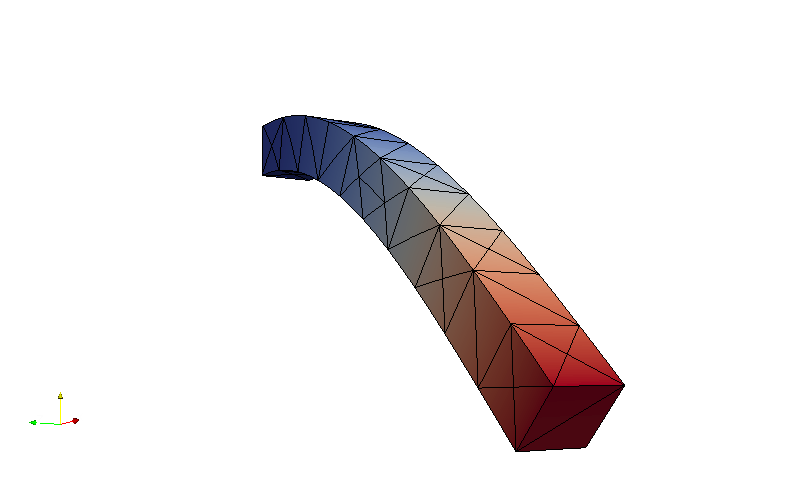

In [63]:
using PyCall
@pyimport IPython.display as d
d.Image("/tmp/3d_solid_model.png")